In [107]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [108]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [109]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [110]:
block_size = 3

def build_dataset(words):
	X, Y = [], []

	for word in words:
		context = [0] * block_size
		for ch in word + '.':
			ix = stoi[ch]
			X.append(context)
			Y.append(ix)
			# print(''.join(itos[i] for i in context))
			context = context[1:] + [ix]

	X = torch.tensor(X)
	Y = torch.tensor(Y)

	print(X.shape, Y.shape)
	return X, Y

In [111]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
emb_size = 15
neurons_num = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((27, emb_size), generator=g)
W1 = torch.randn((emb_size*block_size, neurons_num), generator=g)
b1 = torch.randn(neurons_num, generator=g)
W2 = torch.randn((neurons_num, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [153]:
import math

emb_size = 15
neurons_num = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, emb_size), generator=g) * (1.0 / math.sqrt(emb_size))
W1 = torch.randn((emb_size * block_size, neurons_num), generator=g) * (1.0 / math.sqrt(emb_size * block_size))
b1 = torch.zeros(neurons_num)
W2 = torch.randn((neurons_num, 27), generator=g) * (1.0 / math.sqrt(neurons_num))
b2 = torch.zeros(27)

parameters = [C, W1, b1, W2, b2]


In [155]:
sum(p.nelement() for p in parameters) # number of parameters in total

15032

In [156]:
for p in parameters:
	p.requires_grad = True

In [130]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [157]:
lri = []
stepi = []
lossi = []

In [158]:
for i in range(200000):
	ix = torch.randint(0, Xtr.shape[0], (32,))

	emb = C[Xtr[ix]]
	h = torch.tanh(emb.view(-1, emb_size*block_size) @ W1 + b1)
	logits = h @ W2 + b2

	loss = F.cross_entropy(logits, Ytr[ix])

	for p in parameters:
		p.grad = None

	loss.backward()
	print(loss.item())

	lr = 0.1 if i < 100000 else 0.01
	# lr = lrs[i]
	for p in parameters:
		p.data += -lr * p.grad
	
	# lri.append(lre[i])
	stepi.append(i)
	lossi.append(loss.log10().item())

3.194652795791626
3.3721377849578857
3.318525791168213
3.225069999694824
3.226828098297119
3.2231335639953613
3.2223331928253174
3.115622043609619
3.166628360748291
3.2008562088012695
3.1055662631988525
3.143050193786621
3.0978362560272217
3.083024501800537
3.101477861404419
3.0501270294189453
3.148488998413086
3.0101048946380615
3.1609933376312256
3.0538177490234375
3.100126028060913
2.9210448265075684
3.1078073978424072
2.996432065963745
2.9268124103546143
2.978692054748535
3.0203349590301514
3.036587953567505
2.9872448444366455
3.176015853881836
2.9464447498321533
2.998380422592163
2.9043052196502686
2.90873646736145
2.8242909908294678
2.90883731842041
3.11501407623291
2.9841344356536865
2.8884871006011963
2.804192543029785
2.731853485107422
2.8715949058532715
2.906266689300537
2.777822971343994
2.9625632762908936
2.6666221618652344
3.0091164112091064
2.901547908782959
2.6698503494262695
3.0391428470611572
3.090583324432373
2.8203237056732178
2.806880474090576
2.529405117034912
2.93

In [159]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_size*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0390, grad_fn=<NllLossBackward0>)

In [160]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_size*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0981, grad_fn=<NllLossBackward0>)

In [161]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_size*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0390, grad_fn=<NllLossBackward0>)

In [162]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amorie.
khi.
miliathal.
skanden.
jazonel.
deliah.
jareen.
nellara.
chaiir.
kaleigh.
ham.
joce.
quintis.
lilea.
jadilyn.
jero.
dearynix.
kaellinsley.
dae.


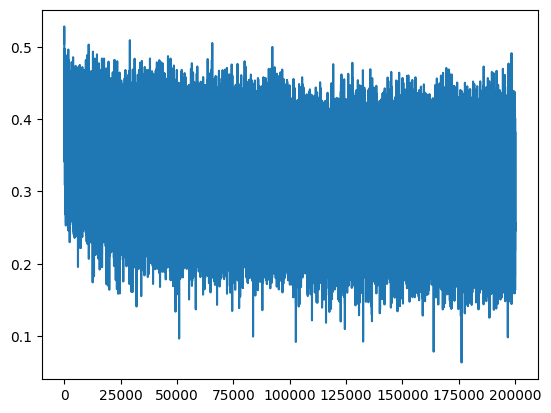

In [163]:
plt.plot(stepi, lossi)

ValueError: x and y must have same first dimension, but have shapes (0,) and (200000,)

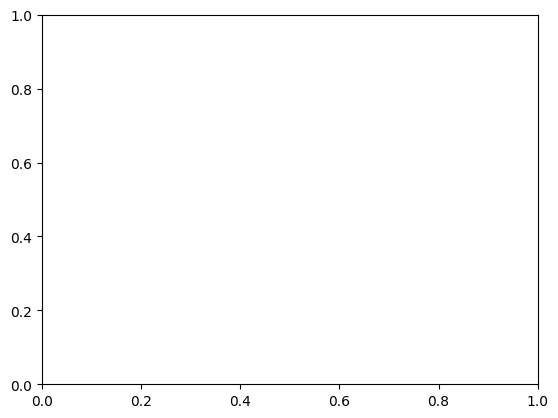

In [120]:
plt.plot(lri, lossi)

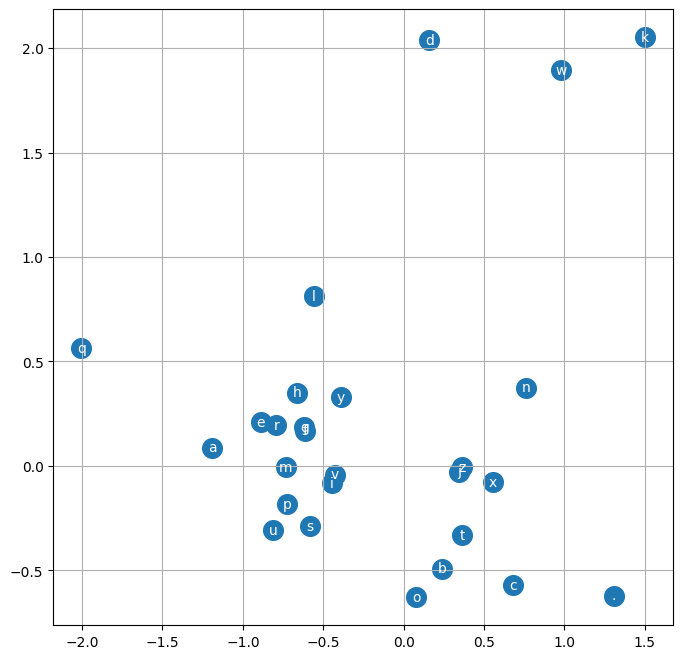

In [124]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')